# Project Goal

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. Our goal is to train a model to automatically detect negative reviews. We'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. We aim to have an F1 score of at least 0.85.

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Initialization

In [2]:
!pip install spacy

In [3]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import random
import nltk
import re
import spacy
from tqdm.auto import tqdm
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm
from lightgbm import LGBMClassifier
import torch
import transformers

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [6]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

# Load Data

In [7]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [8]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [9]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


There were 47331 rows of data. Our goal is to use 'review' for the features and 'pos' for the target to train our model so we are not going to focus on preprocessing the other columns. Let's explore the data.

# Exploratory Data Analysis

Let's check the number of movies and reviews over years.

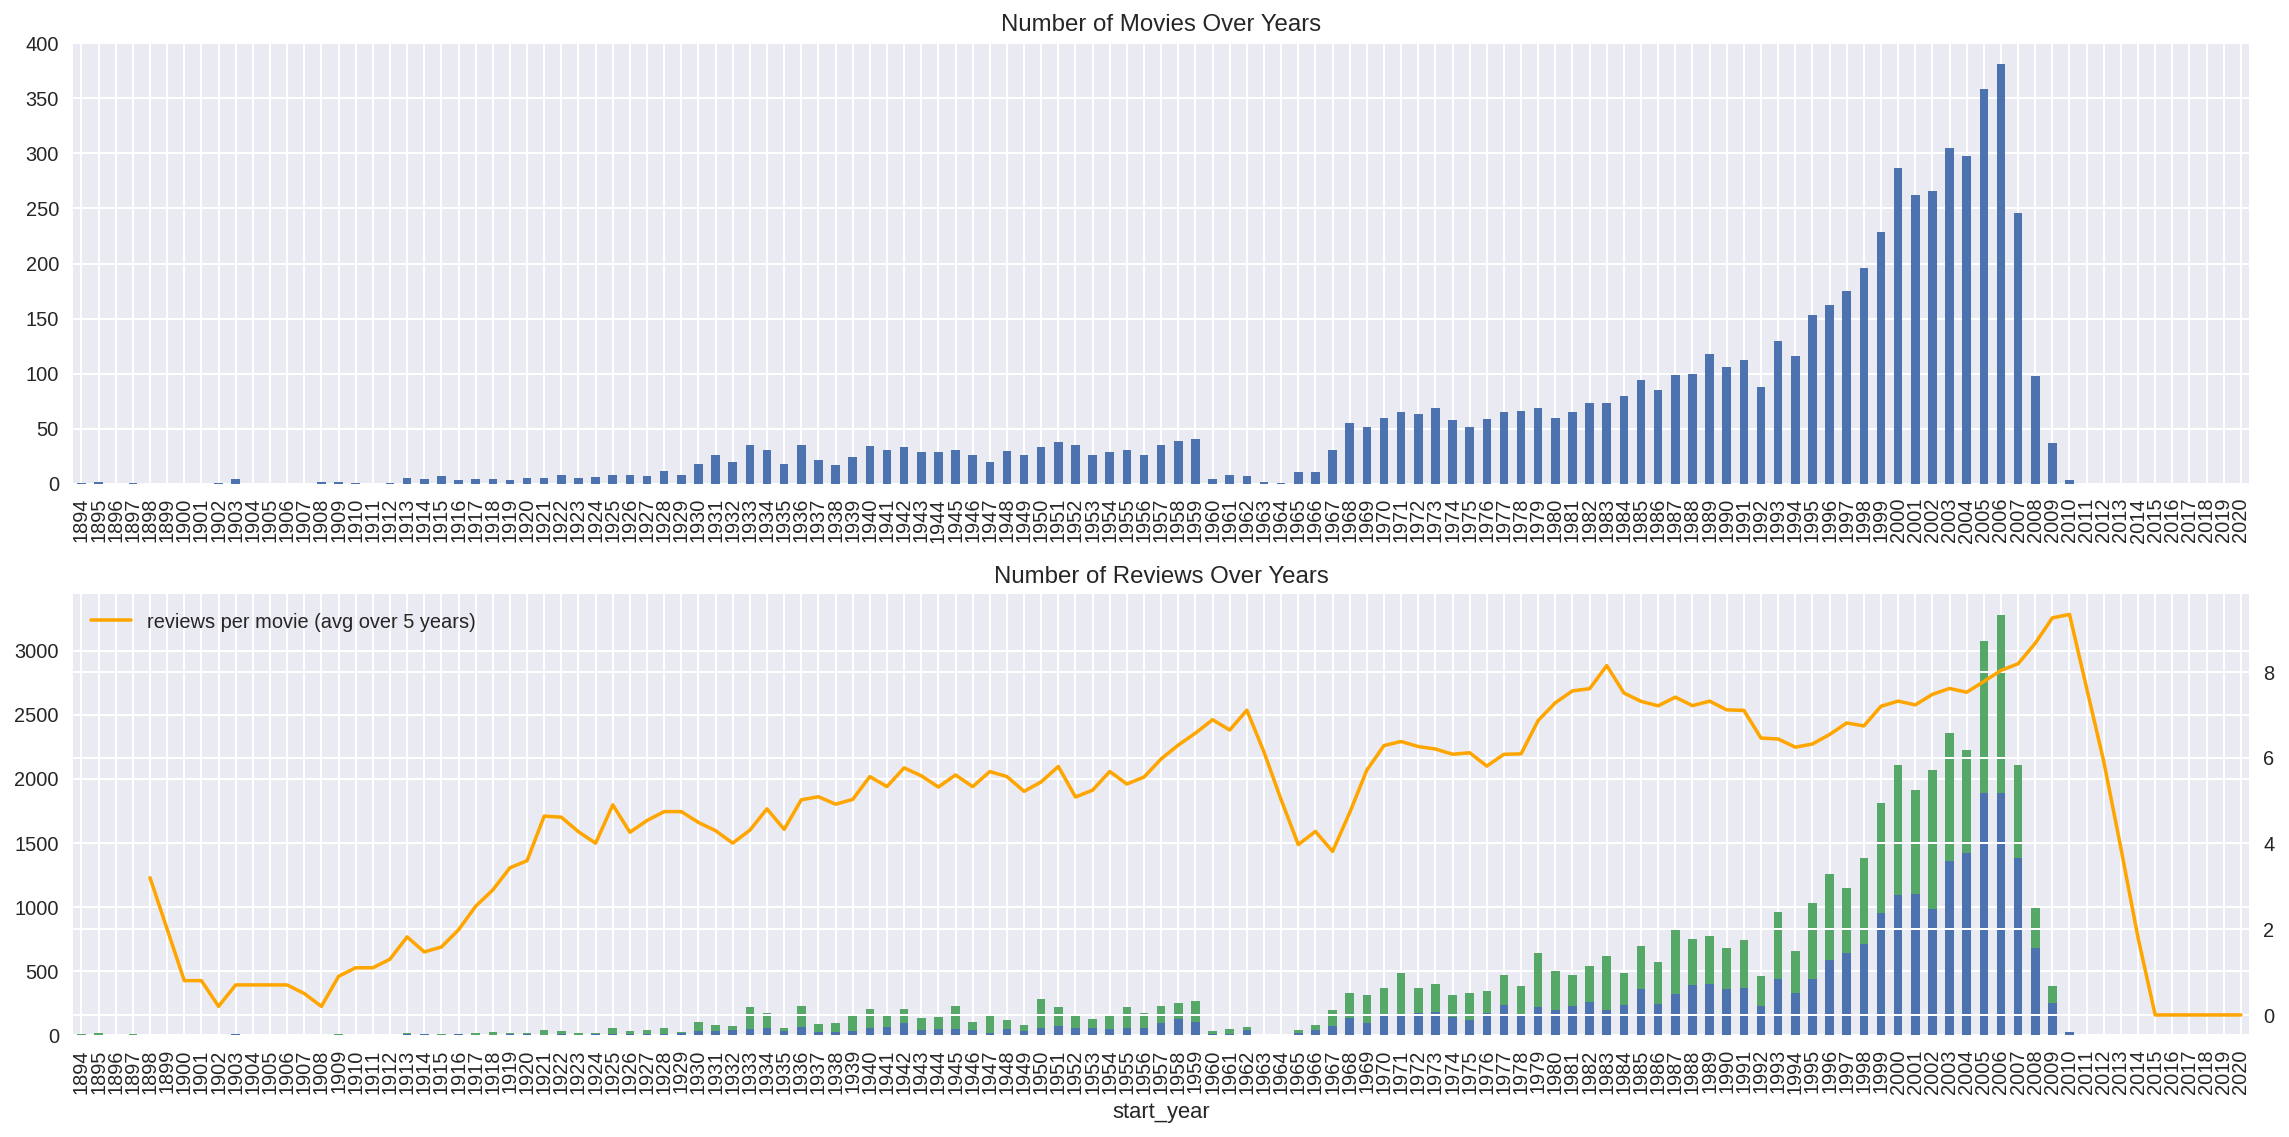

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

The number of reviews per movie generally increases over time, peaking at year 2006.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

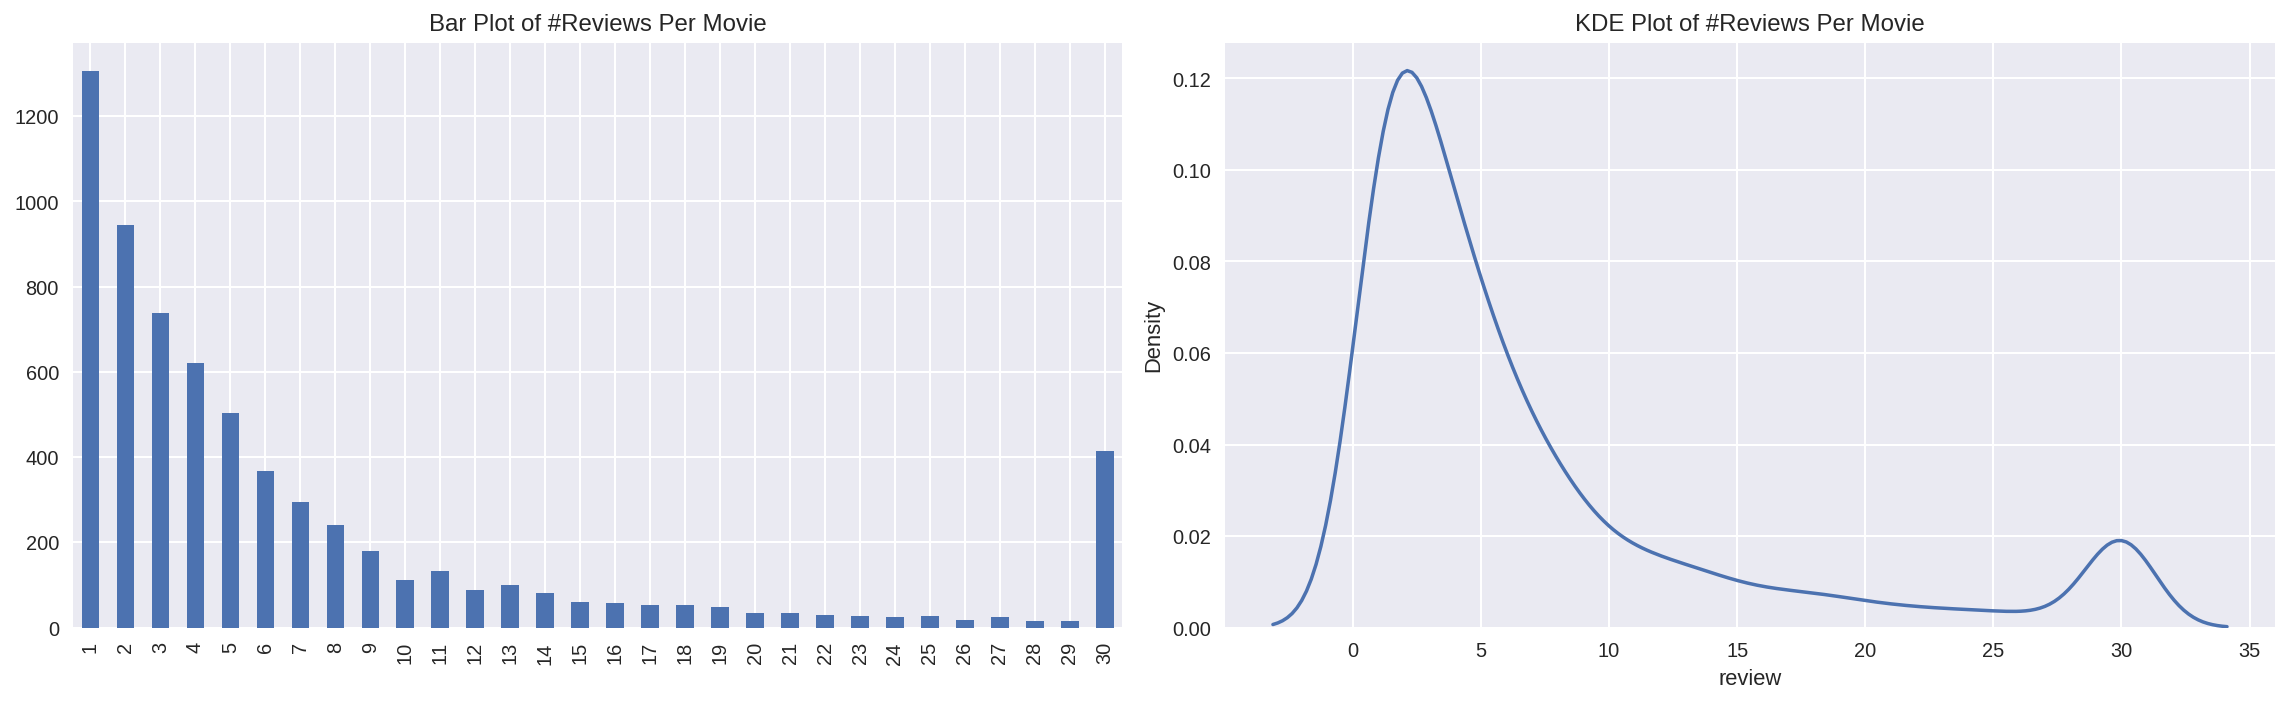

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The range of reviews per movie was less than 50 to over 1200 reviews.

In [12]:
# Checking the distribution of positive to negative reviews

df_reviews['pos'].value_counts(normalize = True)

0    0.501046
1    0.498954
Name: pos, dtype: float64

The ratio of positive to negative reviews in the data is about 1:1 so we do not need to correct any class imbalance.

Let's plot the distribution of positive to negative reviews in the train and test sets.

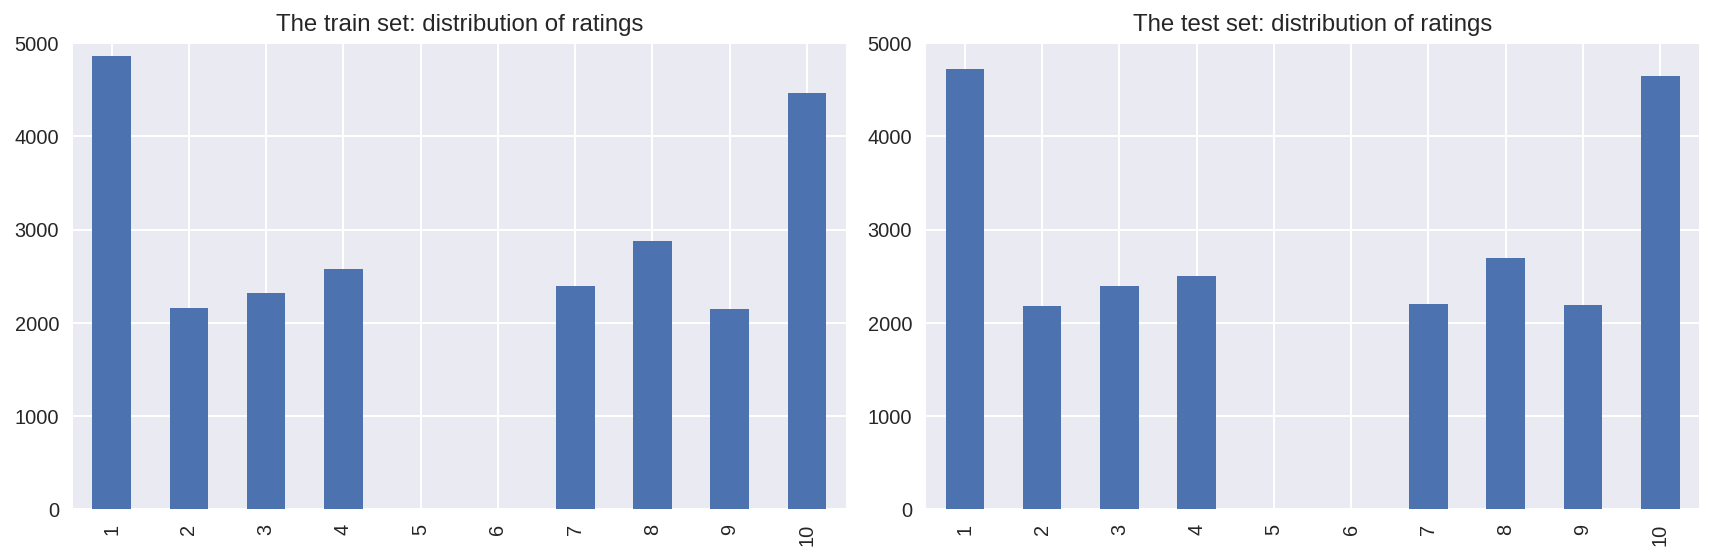

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The distribution of positive to negative reviews is similar for the train and test sets.

Checking the distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


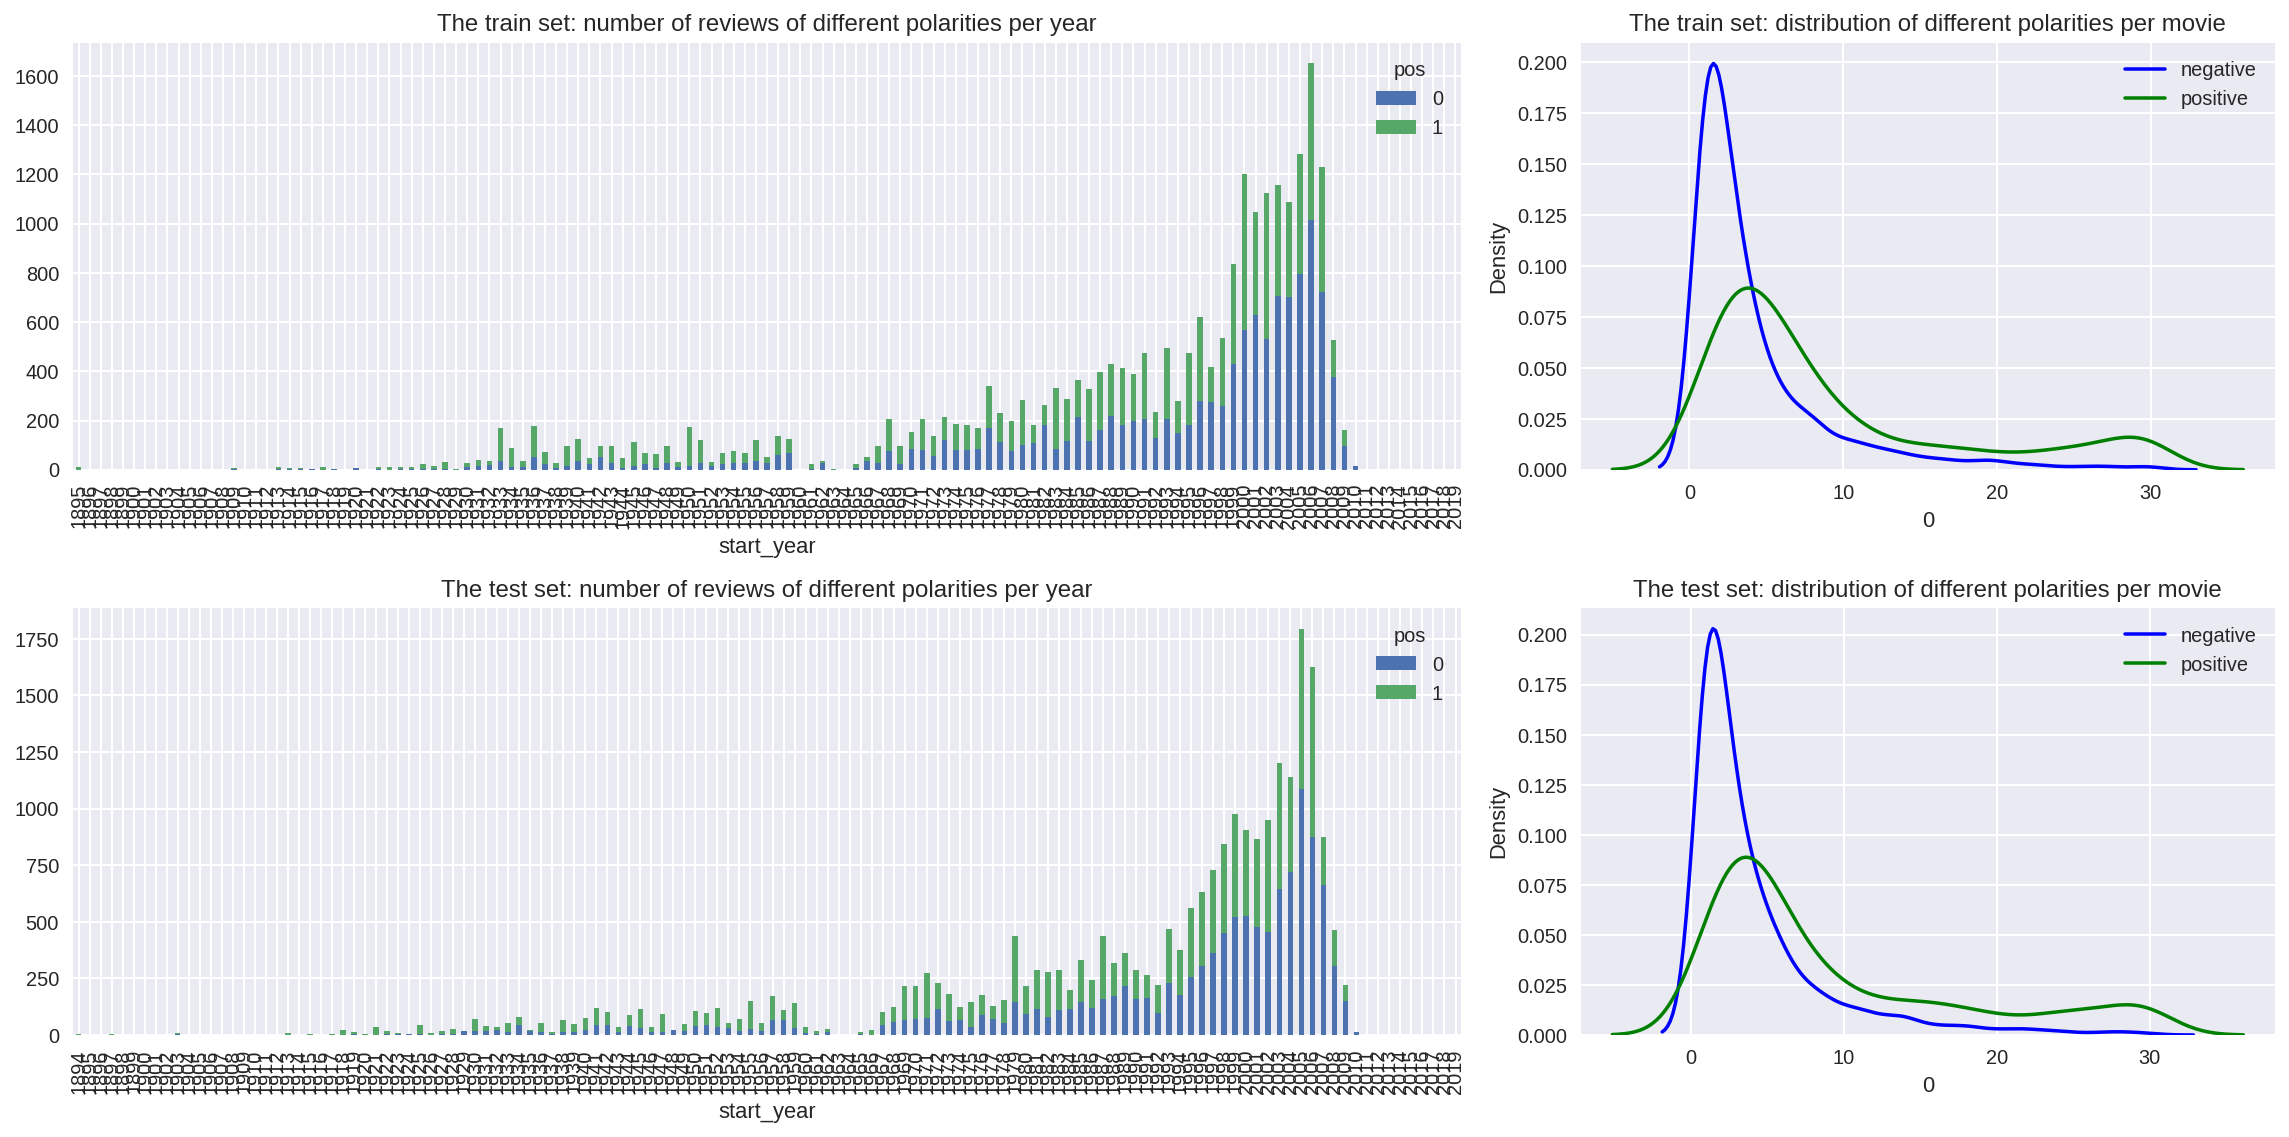

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The distribution of positive to negative reviews over the years was similar for the train and test sets.

# Evaluation Procedure

Creating an evaluation routine which can be used for all models in this project

In [22]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

# Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.
Before extracting features, we need to simplify the text.

In [16]:
# Converting reviews to lowercase
df_reviews['review_norm'] = df_reviews['review'].str.lower()

In [17]:
# Removing anything but letters from the text

def clear_text(text):
    
    clean_text = re.sub(r'[^a-zA-z\']', ' ', text)
    clean_text = " ".join(clean_text.split())
    
    return clean_text
df_reviews['review_norm'] = df_reviews['review_norm'].apply(clear_text)

In [18]:
# Removing punctuation from reviews
import string

# create function for punctuation removal:
def remove_punctuations(text):
    for char in string.punctuation:
        text = text.replace(char, '')
    return text

# apply the function:
df_reviews['review_norm'] = df_reviews['review_norm'].apply(remove_punctuations)

In [19]:
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        im totally agree with garryjohal from singapor...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought id say this about a biopic but...
47329    spirit and chaos is an artistic biopic of miya...
47330    ill make this brief this was a joy to watch it...
Name: review_norm, Length: 47331, dtype: object

# Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [20]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


# Working with models

## Model 0 - Constant

We will use a "most frequent" method of DummyClassifier to generate predictions while respecting the class distribution of the training data.

In [23]:
# Creating baseline with DummyClassifer

model_0 = DummyClassifier(strategy = "most_frequent")
model_0 .fit(df_reviews_train, train_target)
predictions = model_0 .predict(df_reviews_test)
score = model_0 .score(predictions, test_target)
score


0.5015083917569577

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


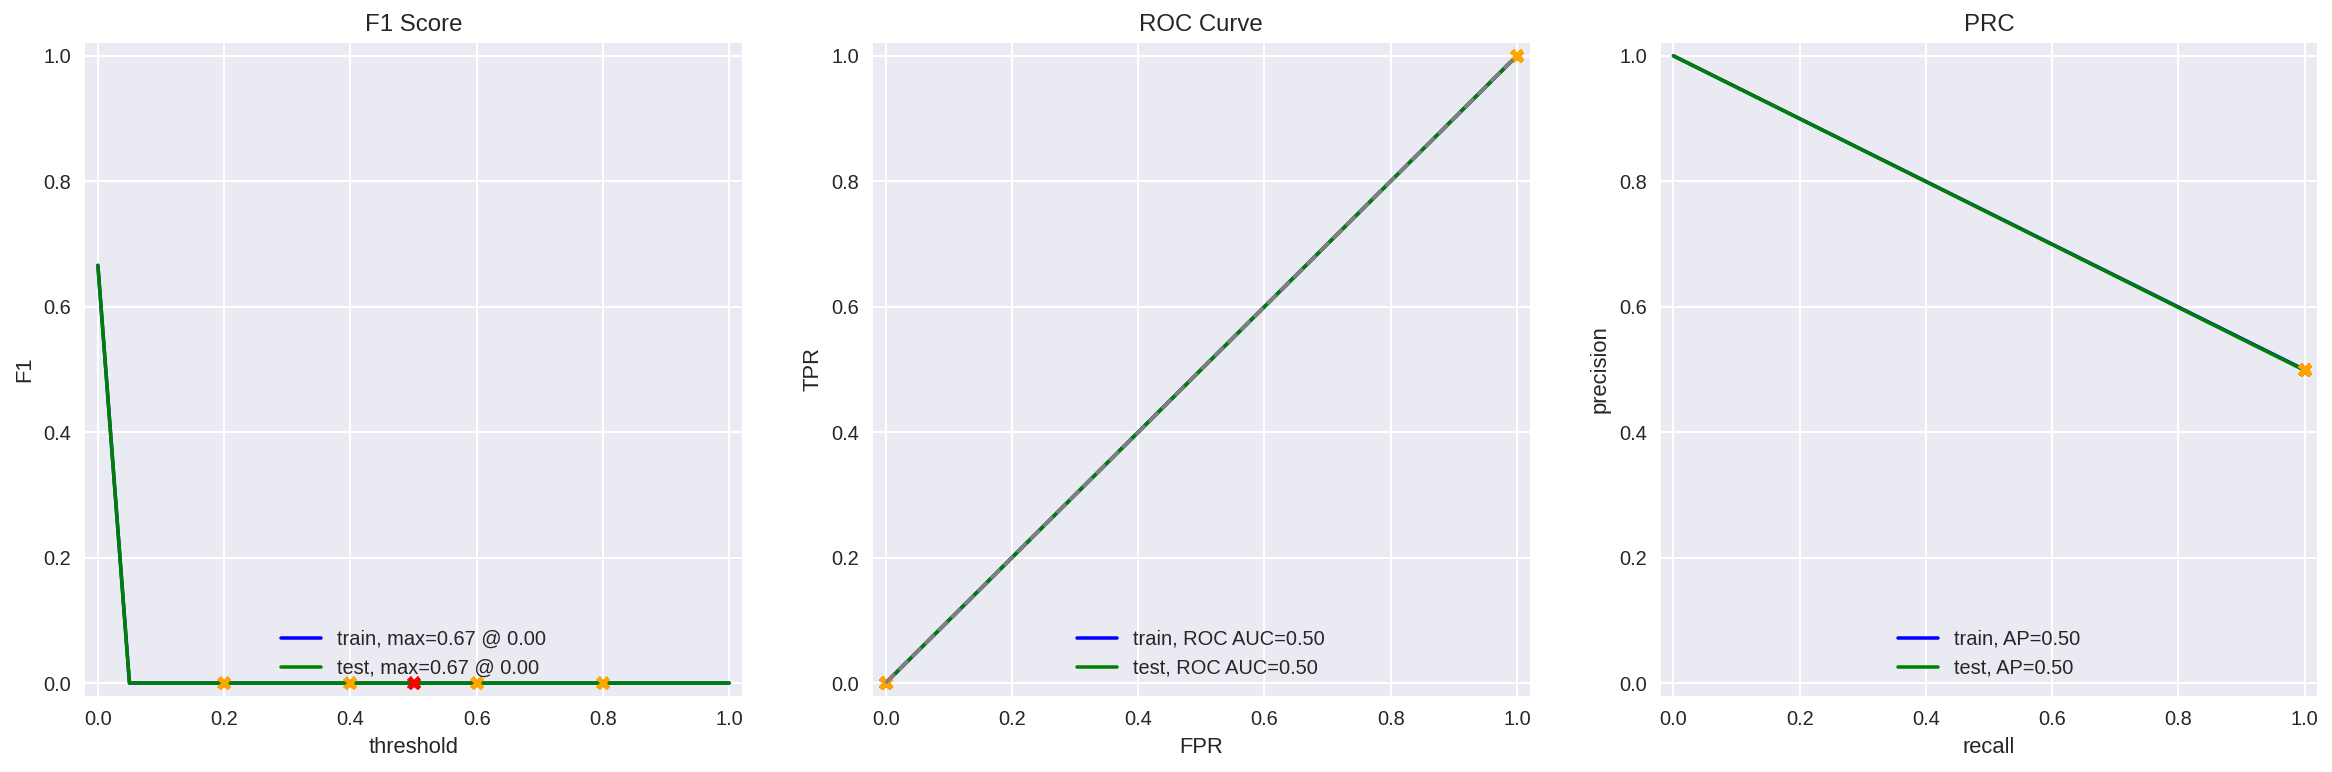

In [24]:
evaluate_model(model_0, df_reviews_train, train_target, df_reviews_test, test_target)

The mean accuracy score of the DummyClassifer was 0.50. There is a 50% chance of the target being positive since that is the frequency of '0' in the data.

## Model 1 - NLTK, TF-IDF and LR

We will lemmatize the reviews using NLTK and extract features using TF-IDF, and train a logistic regression.

In [21]:
# Lemmatize the reviews using WordNetLemmatizer

def lemmatize_nltk(text):
    lemmatizer  = WordNetLemmatizer()
    text_lemmas = lemmatizer.lemmatize(text)
    
    return text_lemmas
df_reviews_train['review_nltk'] = df_reviews_train['review_norm'].apply(lemmatize_nltk)
df_reviews_test['review_nltk'] = df_reviews_test['review_norm'].apply(lemmatize_nltk)

In [22]:
df_reviews_test['review_nltk']

2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        im totally agree with garryjohal from singapor...
5        this is the first movie ive seen from singapor...
6        yes non singaporeans cant see whats the big de...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought id say this about a biopic but...
47329    spirit and chaos is an artistic biopic of miya...
47330    ill make this brief this was a joy to watch it...
Name: review_nltk, Length: 23535, dtype: object

In [23]:
# Creating matrix using train review data

train_corpus = df_reviews_train['review_nltk']

stop_words = nltk_stopwords.words('english')
text_transformer1 = TfidfVectorizer(stop_words=stop_words)

tf_idf_nltk = text_transformer1.fit_transform(train_corpus) 

'The TF-IDF matrix size:', tf_idf_nltk.shape

('The TF-IDF matrix size:', (23796, 75735))

In [24]:
# Creating matrix using test review data

test_corpus = df_reviews_test['review_nltk']

tf_idf_nltk_test = text_transformer1.transform(test_corpus) 

'The TF-IDF matrix size:', tf_idf_nltk_test.shape

('The TF-IDF matrix size:', (23535, 75735))

In [25]:
# Preparing data for model training

train_features_1 = tf_idf_nltk 
train_target = df_reviews_train['pos']
test_features_1 = tf_idf_nltk_test
test_target = df_reviews_test['pos']

In [26]:
# Training LogisticRegression model

model_1 = LogisticRegression(solver='liblinear', random_state=12345)
model_1.fit(train_features_1, train_target)
predictions = model_1.predict(test_features_1)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


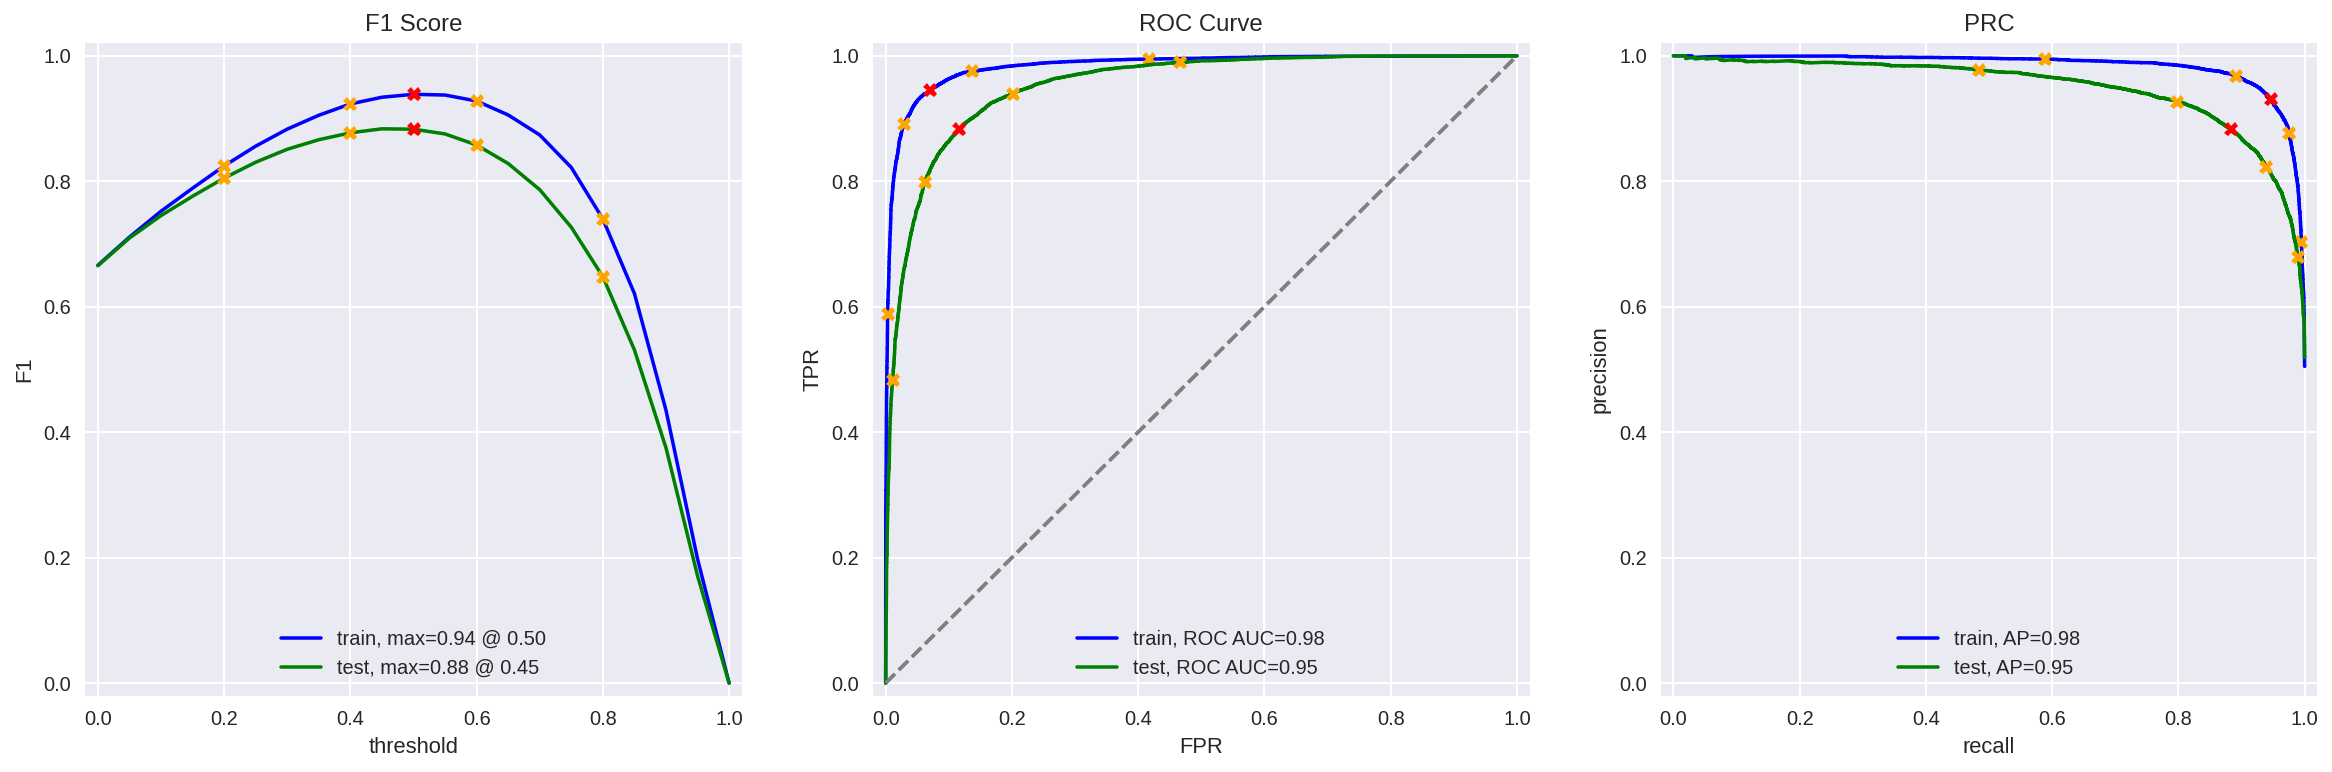

In [27]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

## Model 2 - spaCy, TF-IDF and LR

We will lemmatize the reviews using spaCy, extracted the features using TF-IDF and train a model with Logistic Regression.

In [28]:
# Lemmatize text using spaCy
nlp = spacy.load("en_core_web_sm", disable = ['parser','ner'])

def lemmatize_spacy(text):
    
    doc = nlp(text)
    
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
    return " ".join(lemmas)

In [29]:
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(lemmatize_spacy)
df_reviews_train['review_spacy'] 

0        the pakage imply that warren beatty and goldie...
1        how the hell do they get this make present its...
7        this true story of carlson raider be more of a...
8        should have be title balderdash   little in th...
9        the movie gung ho   the story of carlson makin...
                               ...                        
47253    o my gosh just give I a minute to breath this ...
47254    I can not tell you all how much I love this mo...
47255    legend of zu be possibly the most exciting mov...
47256    this movie be well do on so many level that I ...
47257    as a history nut who be particularly intereste...
Name: review_spacy, Length: 23796, dtype: object

In [30]:
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(lemmatize_spacy)
df_reviews_test['review_spacy']

2        there be no real story the film seem more like...
3        um a serious film about troubled teen in singa...
4        I m totally agree with garryjohal from singapo...
5        this be the first movie I ve see from singapor...
6        yes non singaporean can not see what s the big...
                               ...                        
47326    this be another of my favorite columbo it spor...
47327    talk about be bore I get this expect a fascina...
47328    I never think I d say this about a biopic but ...
47329    spirit and chaos be an artistic biopic of miya...
47330    ill make this brief this be a joy to watch it ...
Name: review_spacy, Length: 23535, dtype: object

In [31]:
# Creating matrix using train review data

train_corpus = df_reviews_train['review_spacy']

stop_words = nltk_stopwords.words('english')
text_transformer2 = TfidfVectorizer(stop_words=stop_words)

tf_idf_spacy = text_transformer2.fit_transform(train_corpus) 

'The TF-IDF matrix size:', tf_idf_spacy.shape

('The TF-IDF matrix size:', (23796, 61534))

In [32]:
# Creating matrix using test review data

test_corpus = df_reviews_test['review_nltk']

tf_idf_spacy_test = text_transformer2.transform(test_corpus) 

'The TF-IDF matrix size:', tf_idf_spacy_test.shape

('The TF-IDF matrix size:', (23535, 61534))

In [33]:
# Preparing data for model training

train_features_2 = tf_idf_spacy 
train_target = df_reviews_train['pos']
test_features_2 = tf_idf_spacy_test
test_target = df_reviews_test['pos']

In [34]:
# Training LogisticRegression model

model_2 = LogisticRegression(solver='liblinear', random_state=12345)
model_2.fit(train_features_2, train_target)
predictions = model_2.predict(test_features_2)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.94


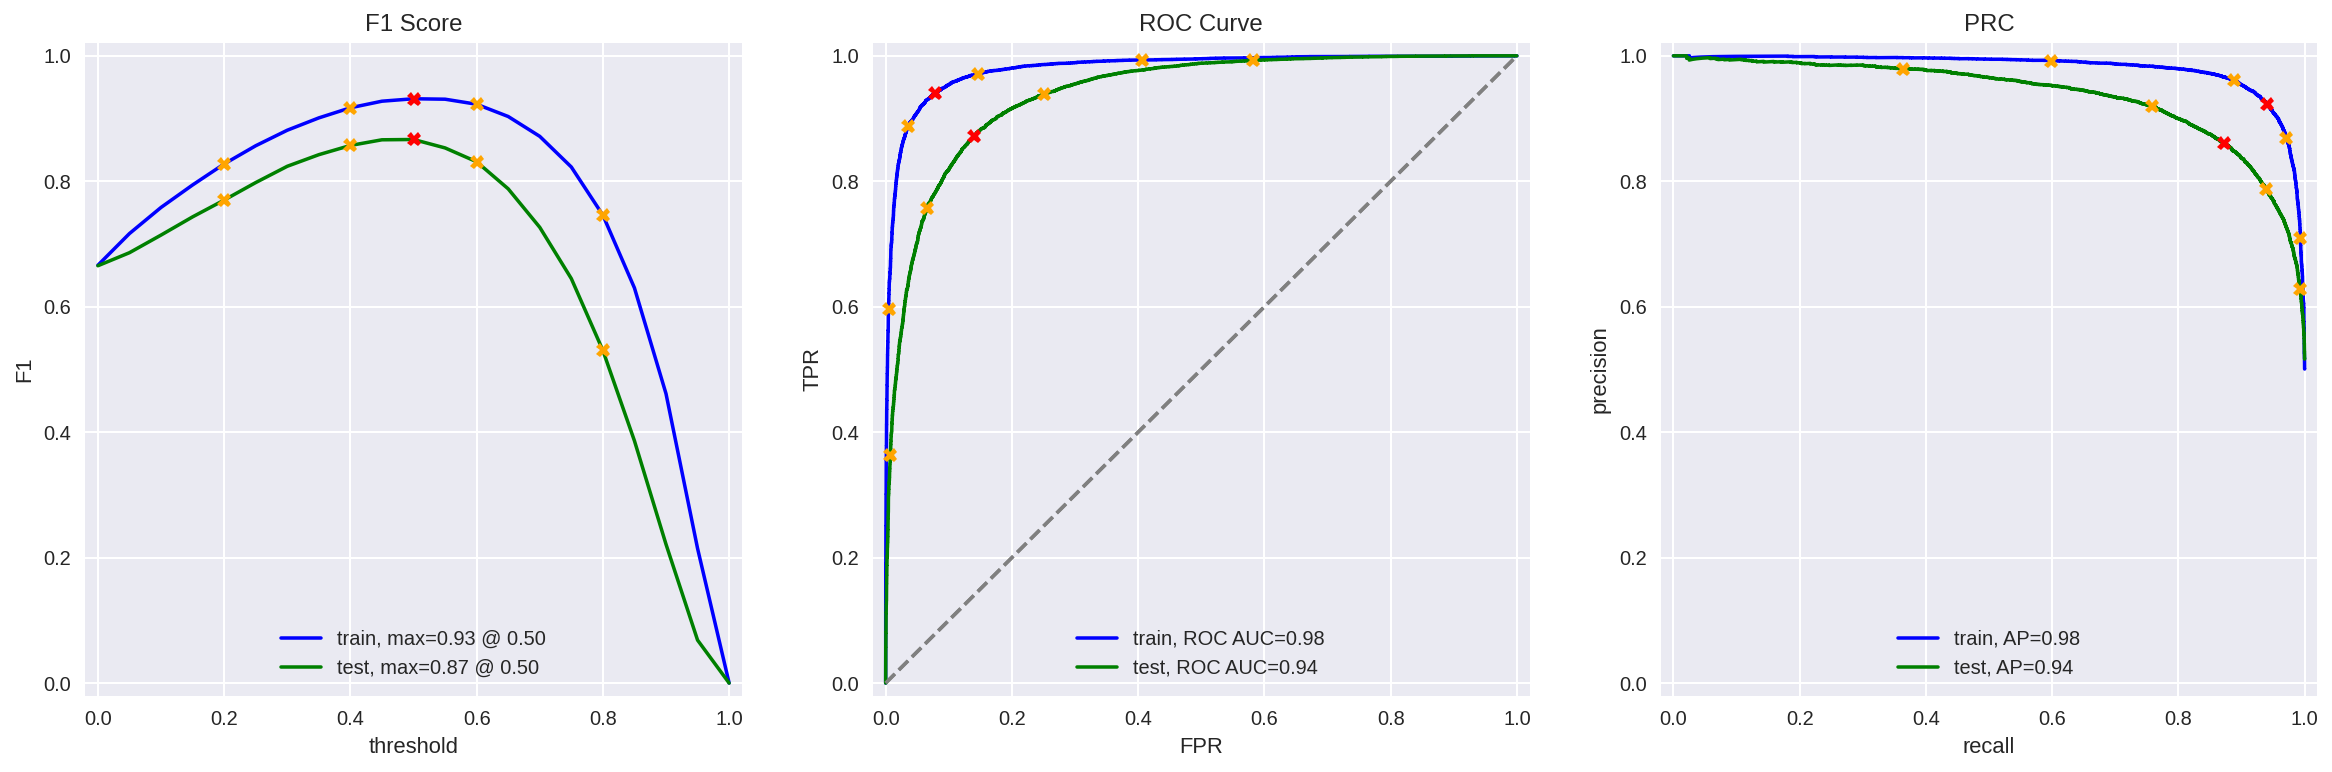

In [35]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

## Model 3 - spaCy, TF-IDF and LGBMClassifier

We will apply the spaCy and TF-IDF data preprocessing to train the LGBM Classifier model.

In [36]:
# Training LGBMClassifier

model_3 = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
model_3.fit(train_features_2, train_target)
predictions = model_3.predict(test_features_2)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


          train  test
Accuracy   0.91  0.84
F1         0.91  0.84
APS        0.97  0.92
ROC AUC    0.97  0.92


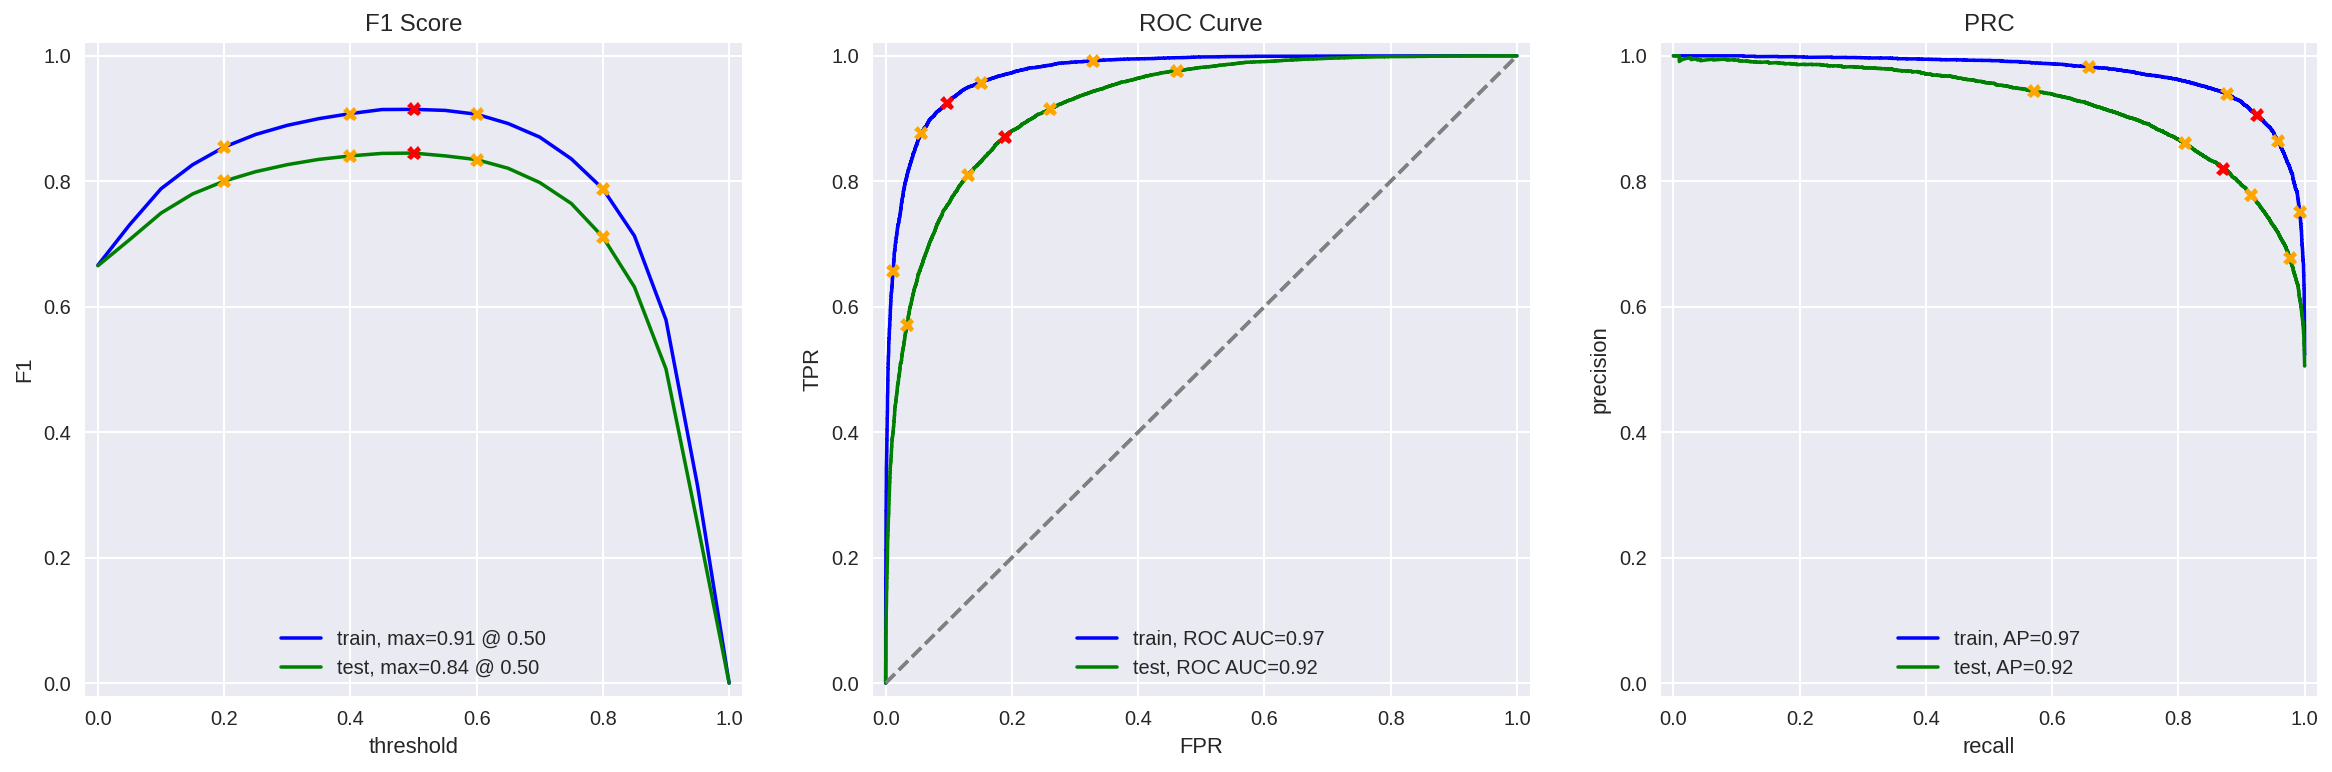

In [37]:
evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

# My Reviews

In [38]:
# Creating new reviews and preprocessing the texts

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.lower()
my_reviews['review_norm'] = my_reviews['review_norm'].apply(clear_text)
my_reviews['review_norm'] = my_reviews['review_norm'].apply(remove_punctuations)

my_reviews['review_norm']

0        i did not simply like it not my kind of movie
1    well i was bored and felt asleep in the middle...
2               i was really fascinated with the movie
3    even the actors looked really old and disinter...
4    i didnt expect the reboot to be so good writer...
5    the movie had its upsides and downsides but i ...
6    what a rotten attempt at a comedy not a single...
7    launching on netflix was a brave move i really...
Name: review_norm, dtype: object

## Model 1
Applying model 1 to the my_reviews.

In [39]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(text_transformer1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didnt expect the reboot to be so good writers really cared about the source material
0.49:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Model 2
Applying model 1 to the my_reviews.

In [40]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(text_transformer2.transform(texts.apply(lambda x: lemmatize_spacy(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didnt expect the reboot to be so good writers really cared about the source material
0.50:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Model 3
Applying model 1 to the my_reviews.

In [41]:
texts = my_reviews['review_norm']

text_transformer3 = text_transformer2
my_reviews_pred_prob = model_3.predict_proba(text_transformer2.transform(texts.apply(lambda x: lemmatize_spacy(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.52:  i did not simply like it not my kind of movie
0.38:  well i was bored and felt asleep in the middle of the movie
0.59:  i was really fascinated with the movie
0.37:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.68:  i didnt expect the reboot to be so good writers really cared about the source material
0.68:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.31:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.81:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


# Conclusions

 - #### Model 1 - NLTK, TF-IDF and LR

We lemmatized the reviews using NLTK and extracted features using TF-IDF, and trained a logistic regression. The F1 score for the test set was 0.88.


 - #### Model 2 - spaCy, TF-IDF and LR

We lemmatized the reviews using spaCy and extracted features using TF-IDF, and trained a logistic regression. The F1 score for the test set was 0.87


 - #### Model 3 - spaCy, TF-IDF and LGBMClassifier

We applied the spaCy and TF-IDF data preprocessing and trained the LGBM Classifier model. The F1 score for the test set was 0.84.


 - #### Model 1 performed the best of all the models.


The class probabilities predicted for the models varied between the three models, due to the differences between the data preprocessing and the models used. The class probabilities for model 3 seemed less accurate than for models 1 and 2. This is similar to the results of the evaluations of models above.
